# GARLIC demo

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Read data

In [226]:
importlib.reload(scripts.read_data)
object_name, data, true_spectrum = scripts.read_data.run(11, (0, 0, 1))
data_offset = np.nanmin(data)

Read dataset 11: "Sky spectrum" (7341,) (0.0108 s)


## Parameter settings

In [227]:
residual_accuracy = .1
max_iter = 100  # in principle, just for safety

# 2. Diffuse emission

In [228]:
importlib.reload(scripts.diffuse_emission)
compact_scale, diffuse_scale, background, residual_above_bg = scripts.diffuse_emission.run(data)

1200 minima => smoothing_scale = 6.1 pixels
   median absolute residual = 0.000e+00, bg_fluctuations = 1.237e+03
686 minima => smoothing_scale = 10.7 pixels
   median absolute residual = 2.602e+00, bg_fluctuations = 1.558e+02
458 minima => smoothing_scale = 16.0 pixels
   median absolute residual = 5.917e+00, bg_fluctuations = 8.064e+01
337 minima => smoothing_scale = 21.8 pixels
   median absolute residual = 8.281e+00, bg_fluctuations = 1.329e+01
238 minima => smoothing_scale = 30.8 pixels
   median absolute residual = 1.043e+01, bg_fluctuations = 2.003e+01
218 minima => smoothing_scale = 33.7 pixels
   median absolute residual = 1.298e+01, bg_fluctuations = 1.108e+01
mean/median background = 1.355e+02/1.398e+02,  residual = 4.572e+02/4.965e+01 (0.0127 s)


In [229]:
importlib.reload(scripts.multiscale_RL)
min_radius = np.sqrt((compact_scale/2)**2 - 1)
smoothing_radii = np.array([min_radius, diffuse_scale])
mRL = scripts.multiscale_RL.run((data - background).clip(min=0), smoothing_radii, .9)

iteration 1/100: rms_residual = 1.27e+03 (+100.00%)
iteration 2/100: rms_residual = 8.42e+02 (-50.95%)
Multiscale Richardson-Lucy deconvolution (0.00854 s)


In [230]:
compact_scale, diffuse_scale, min_radius

(6.1175, 33.674311926605505, 2.890666283488981)

In [231]:
np.sum(data-background), np.sum(mRL[0]), np.sum(mRL[1]), np.sum(mRL)

(nan, 2208144.0371982576, 1066425.2276033447, 3274569.264801602)

In [232]:
new_mRL = mRL.copy()
'''
indices = np.where(mRL[0] < mRL[1])
new_mRL[1][indices] += mRL[0][indices]
new_mRL[0][indices] = 0
indices = np.where(mRL[0] < mRL[2])
new_mRL[2][indices] += mRL[0][indices]
new_mRL[0][indices] = 0
indices = np.where(mRL[1] < mRL[2])
new_mRL[2][indices] += mRL[1][indices]
new_mRL[1][indices] = 0
'''

'''
indices = np.where(mRL[1] < mRL[2])
new_mRL[2][indices] += mRL[1][indices]
new_mRL[1][indices] = 0
indices = np.where(mRL[0] < mRL[2])
new_mRL[2][indices] += mRL[0][indices]
new_mRL[0][indices] = 0
indices = np.where(mRL[1] < mRL[0])
new_mRL[0][indices] += mRL[1][indices]
new_mRL[1][indices] = 0
'''


'\nindices = np.where(mRL[1] < mRL[2])\nnew_mRL[2][indices] += mRL[1][indices]\nnew_mRL[1][indices] = 0\nindices = np.where(mRL[0] < mRL[2])\nnew_mRL[2][indices] += mRL[0][indices]\nnew_mRL[0][indices] = 0\nindices = np.where(mRL[1] < mRL[0])\nnew_mRL[0][indices] += mRL[1][indices]\nnew_mRL[1][indices] = 0\n'

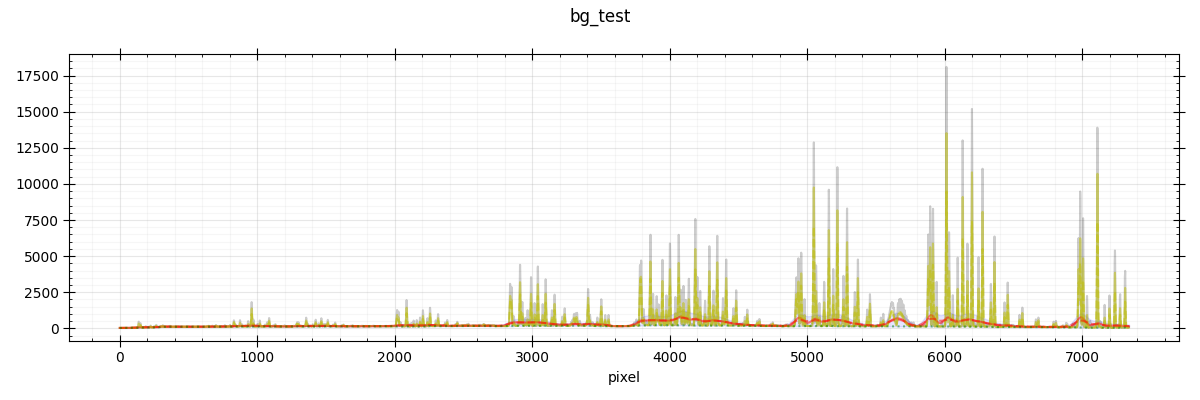

In [233]:
fig_name = 'bg_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False)
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

if true_spectrum is not None:
    ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)

#ax.plot(estimate, 'r-', alpha=.2)
#ax.plot(np.arange(data.size)[index_minima], estimate[index_minima], 'k+')

#ax.plot(model_emission, 'b-', alpha=.5)
#ax.plot(diffuse_emission, 'g--', alpha=.5)
#ax.plot(background + ndimage.gaussian_filter(mRL[0], 1), 'y-', alpha=.5)
#ax.plot(background + ndimage.gaussian_filter(mRL[2], diffuse_scale), 'g-', alpha=.5)
#ax.plot(background + ndimage.gaussian_filter(mRL[1], compact_scale), 'r-', alpha=.5)
ax.plot(background + new_mRL[0], 'y-', alpha=.5)
ax.plot(background + new_mRL[1], 'r-', alpha=.5)
ax.plot(background + ndimage.gaussian_filter(new_mRL[0], smoothing_radii[0]), 'y--', alpha=.5)
ax.plot(background + ndimage.gaussian_filter(new_mRL[1], smoothing_radii[1]), 'r--', alpha=.5)
#ax.fill_between(np.arange(data.size), diffuse_emission - mean_below, diffuse_emission + mean_below, color='g', alpha=.1)
ax.plot(background, 'g:', alpha=.5)
ax.fill_between(np.arange(data.size), background, background + 2*ndimage.gaussian_filter(new_mRL[1], diffuse_scale), color='b', alpha=.1)
#ax.plot(background + np.sum(mRL, axis=0), 'r-', alpha=.5)

ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)
#ax.set_ylim(np.min(background-(diffuse_emission-background)), np.max(diffuse_emission+2*(diffuse_emission-background)))
#ax.set_ylim(0, 300)
#ax.set_xlim(0, 1300)

#ax.plot(diffuse_weight, 'g--', alpha=.5)
#ax.set_ylim(0, 1)

plt.show()


# 3. Source finding

## Hierarchical Overdensity Tree

In [25]:
importlib.reload(scripts.sort_data)
#argsorted_data, n_valid = scripts.sort_data.run(RL.ravel())
argsorted_data, n_valid = scripts.sort_data.run(mRL.ravel())

Sorted 22023 finite measurements in ascending order (0.0051 s)


In [26]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(mRL.strides)//mRL.itemsize, mRL.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
HOT_labels, HOT_catalog = scripts.HOT.run(mRL, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 587 overdensities found, 22023 "pixels" (100%), 8 independent regions
     1.45 seconds


In [27]:
HOT_parent = HOT_catalog[0]
HOT_bg = HOT_catalog[3]
'''
HOT_area = HOT_catalog[1]
HOT_test_stat = HOT_catalog[2]
HOT_bg = HOT_catalog[3]
#max_test_stat = catalog[3]
'''
,

''

## Individual sources

In [28]:
def get_mRL_inpaint(mRL, labels, target):
    raise -1


def get_mRL_inpaint_OLD(mRL, labels, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices]
    #print(f'mRL {target} (area = {len(indices[0])}): {np.nanmax(mRL_target)} {np.nanmax(mRL[indices])}')

    radius = np.sqrt(mRL.shape[0])
    inpaint_map = np.where(mRL_target > 0, 1., 0.)  # object mask
    if len(inpaint_map[0]) > 0:
        inpaint_map = ndimage.gaussian_filter(inpaint_map, radius)  # interpolation weight
        inpaint_map = np.where(inpaint_map > 0, inpaint_map, np.nan)  # to prevent division by zero
        inpaint_map = ndimage.gaussian_filter(mRL_target, radius) / inpaint_map
    else:
        inpaint_map = mRL_target

    return mRL_target, np.fmin(inpaint_map, mRL)


def get_individual_mRL_OLD(mRL, labels, parent, target):

    mRL_target, inpaint_map = get_mRL_inpaint(mRL, labels, target)
    #print(f'mRL {target}: {np.nanmax(mRL_target)}')
    
    # compute contribution to descendants:
    progenitor = np.array(parent[labels])
    if parent[target] == target:
        indices = np.where(labels == target)
        progenitor[indices] = 0
    n_found = 1
    while n_found > 0:
        indices = np.where(progenitor == target)
        n_found = len(indices[0])
        #print(f'{n_found} values painted for {target} ({np.unique(parent[progenitor][indices])})')
        #print(f'{np.unique(labels[indices])}')
        #print(f'{parent[np.unique(labels[indices])]}')
        mRL_target[indices] = inpaint_map[indices]
        progenitor[indices] = 0
        progenitor = parent[progenitor]

    # remove contribution from ancestors:
    inpaint_map = get_mRL_inpaint(mRL, labels, parent[target])[1]
    indices = np.where(labels == target)
    #print(f'Removing {parent[target]} from {target}: {np.nanmax(mRL_target[indices])} {np.nanmax(inpaint_map[indices])}')
    mRL_target[indices] -= inpaint_map[indices]

    return mRL_target


def get_individual_mRL(mRL, labels, parent, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices] - HOT_bg[target]
    
    # add descendants background:
    progenitor = np.array(parent[labels])
    if parent[target] == target:
        indices = np.where(labels == target)
        progenitor[indices] = 0
    n_found = 1
    while n_found > 0:
        indices = np.where(progenitor == target)
        n_found = len(indices[0])
        #print(f'{n_found} values painted for {target} ({np.unique(parent[progenitor][indices])})')
        #print(f'{np.unique(labels[indices])}')
        #print(f'{parent[np.unique(labels[indices])]}')
        mRL_target[indices] = HOT_bg[labels][indices]
        progenitor[indices] = 0
        progenitor = parent[progenitor]

    return mRL_target

In [29]:
'''
get_individual_mRL(mRL, HOT_labels, HOT_parent, 89)

get_individual_mRL(mRL, HOT_labels, HOT_parent, 100)

get_mRL_inpaint(mRL, HOT_labels, 89)

indices = np.where(HOT_labels == 100)
print(indices)
print(mRL[indices])

print(np.mean(mRL[0]))
'''
,

''

In [31]:
true_source = np.zeros(HOT_parent.size, dtype=bool)
diffuse_mRL = mRL.copy()
diffuse_emission = ndimage.gaussian_filter(np.sum(diffuse_mRL, axis=0), diffuse_scale)
diffuse_noise = ndimage.gaussian_filter(diffuse_mRL[0], 1) + ndimage.gaussian_filter(diffuse_mRL[1], compact_scale) + ndimage.gaussian_filter(diffuse_mRL[2], diffuse_scale)
diffuse_noise -= diffuse_emission
diffuse_emission += background

compact_mRL = mRL - diffuse_mRL
compact_emission = ndimage.gaussian_filter(compact_mRL[0], 1) + ndimage.gaussian_filter(compact_mRL[1], compact_scale) + ndimage.gaussian_filter(compact_mRL[2], diffuse_scale)

RL = background + np.sum(mRL, axis=0)
below = np.where((data < model_emission) & (data < RL))
median_below_model = np.nanmedian((RL - data)[below])
below = np.where(data < diffuse_emission)
median_below_diffuse = np.nanmedian((diffuse_emission - data)[below])

median_noise = np.nanmedian(np.abs(data - model_emission))
std_noise = np.nanstd(data - model_emission)
median_residual = np.nanmedian(np.abs(data - diffuse_emission - compact_emission))
std_residual = np.nanstd(data - diffuse_emission - compact_emission)
std_diffuse_noise = np.nanstd(diffuse_noise)

n_iter = 0
next_source = -1
while next_source != 0 and std_diffuse_noise > std_noise:
    n_iter += 1
    print(f'> {n_iter:2d} data-model: {median_noise:.3g} +- {std_noise:.3g}')
    print(f'   residual: {median_residual:.3g} +- {std_residual:.3g}; diffuse noise: {std_diffuse_noise:.3g} ({np.sqrt(std_noise**2 + std_diffuse_noise**2):.3g})')
    print(f'   diffuse noise: {np.nanmean(diffuse_noise):.3g}, {np.nanmedian(diffuse_noise):.3g} +- {std_diffuse_noise:.3g}')
    print(f'   median: {median_below_diffuse:.3g}, {median_below_model:.3g} ')
    print(f'   diffuse-model std: {np.nanstd(diffuse_emission):.3g}, {np.nanstd(model_emission):.3g}, {np.nanstd(model_emission-diffuse_emission):.3g}, ')
    above = model_emission > diffuse_emission
    n_above = np.count_nonzero(above)
    print(f'   above ({n_above}): {np.nansum((data-diffuse_emission)[above]):.3g} +- {np.nanstd((data-diffuse_emission)[above]):.3g};  {np.nansum((model_emission-diffuse_emission)[above]):.3g} +- {np.nanstd((model_emission-diffuse_emission)[above]):.3g}; ')
    print(f'   below ({data.size-n_above}): {np.nansum((diffuse_emission-data)[~above]):.3g} +- {np.nanstd((diffuse_emission-data)[~above]):.3g};  {np.nansum((diffuse_emission-model_emission)[~above]):.3g} +- {np.nanstd((model_emission-diffuse_emission)[~above]):.3g}; *{np.nanmedian(np.abs(diffuse_emission-model_emission)[~above]):.3g}*')
    #print(f'   below (median data-diffuse):  *{median_below:.3g}* +- {np.nanstd(np.abs(diffuse_emission-data)[~above]):.3g}')
    max_flux_excess = 0.
    next_source = 0
    for lbl in np.unique(HOT_labels):
        if true_source[lbl] == False:
            RL = get_individual_mRL(mRL, HOT_labels, HOT_parent, lbl)
            flux_diff = background + np.sum(RL, axis=0) - diffuse_emission
            flux_excess = np.nansum(flux_diff[flux_diff > 0])
            if flux_excess > max_flux_excess:
                #print(lbl, flux_excess)
                max_flux_excess = flux_excess
                next_source = lbl
    print(f'   next source = {next_source} (flux excess = {max_flux_excess:.3g})')
    true_source[next_source] = True
    diffuse_mRL[HOT_labels == next_source] = 0
    diffuse_emission = ndimage.gaussian_filter(np.sum(diffuse_mRL, axis=0), diffuse_scale)
    diffuse_noise = ndimage.gaussian_filter(diffuse_mRL[0], 1) + ndimage.gaussian_filter(diffuse_mRL[1], compact_scale) + ndimage.gaussian_filter(diffuse_mRL[2], diffuse_scale)
    diffuse_noise -= diffuse_emission
    diffuse_emission += background
    compact_mRL = mRL - diffuse_mRL
    compact_emission = ndimage.gaussian_filter(compact_mRL[0], 1) + ndimage.gaussian_filter(compact_mRL[1], compact_scale) + ndimage.gaussian_filter(compact_mRL[2], diffuse_scale)
    below = np.where(model_emission < diffuse_emission)
    median_below = np.nanmedian(np.abs(data-diffuse_emission)[below])
    below = np.where(data < diffuse_emission)
    median_below_diffuse = np.nanmedian((diffuse_emission - data)[below])
    median_residual = np.nanmedian(np.abs(data - diffuse_emission - compact_emission))
    std_residual = np.nanstd(data - diffuse_emission - compact_emission)
    std_diffuse_noise = np.nanstd(diffuse_noise)
    
    print()


>  1 data-model: 5.5 +- 45.1
   residual: 229 +- 1.2e+03; diffuse noise: 1.18e+03 (1.18e+03)
   diffuse noise: 5.01e-14, -93.8 +- 1.18e+03
   median: 187, 8.24 
   diffuse-model std: 421, 1.27e+03, 1.18e+03, 
   above (1693): 1.98e+06 +- 1.97e+03;  1.97e+06 +- 1.97e+03; 
   below (5648): 1.92e+06 +- 372;  1.97e+06 +- 363; *200*
   next source = 1 (flux excess = 9.53e+04)

>  2 data-model: 5.5 +- 45.1
   residual: 229 +- 1.13e+03; diffuse noise: 1.11e+03 (1.12e+03)
   diffuse noise: 4.66e-14, -93.9 +- 1.11e+03
   median: 186, 8.24 
   diffuse-model std: 393, 1.27e+03, 1.19e+03, 
   above (1701): 2e+06 +- 1.99e+03;  2e+06 +- 1.99e+03; 
   below (5640): 1.84e+06 +- 343;  1.89e+06 +- 334; *199*
   next source = 3 (flux excess = 7.48e+04)

>  3 data-model: 5.5 +- 45.1
   residual: 224 +- 1.08e+03; diffuse noise: 1.07e+03 (1.07e+03)
   diffuse noise: 4.31e-14, -94.2 +- 1.07e+03
   median: 181, 8.24 
   diffuse-model std: 388, 1.27e+03, 1.19e+03, 
   above (1709): 2.02e+06 +- 1.99e+03;  2.01e

In [33]:
median_below_diffuse, median_below_model, std_diffuse_noise

(4.854862576657695, 8.24339675137412, 34.173777888009454)

In [34]:
compact_mRL = mRL - diffuse_mRL
compact_emission = ndimage.gaussian_filter(compact_mRL[0], 1) + ndimage.gaussian_filter(compact_mRL[1], compact_scale) + ndimage.gaussian_filter(compact_mRL[2], diffuse_scale)


# 3. Plots

Normalisation and color maps:

In [35]:
n_sources = np.unique(HOT_labels).size
latin_cube = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
latin_cube[0, :] = [0., 0., 0., 1.]  # background object must be black :^)
label_cmap = colors.ListedColormap(latin_cube)
label_norm = colors.Normalize(vmin=-.5, vmax=n_sources+.5)
print(f'{n_sources} unique sourcces')

587 unique sourcces


In [36]:
mRL_cmap = default_cmap
mRL_norm = colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99))

In [37]:
n_above, np.count_nonzero(model_emission > diffuse_emission), np.where(model_emission < diffuse_emission)

(6425,
 6469,
 (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
           11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
           22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
           33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
           44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
           55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
           66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
           77,   78,   79,   80,   81,   82,   83,   84,   85,  374,  375,
          376,  377,  378,  379,  380,  381,  382,  383,  384,  385,  386,
          387,  388,  389,  390,  391,  394,  395,  396,  397,  400,  401,
          402,  403,  404,  405,  406,  407,  408,  420,  421,  432,  433,
          434,  435,  436,  437,  443,  444,  445,  446,  447,  448,  449,
          450,  451,  455,  456,  457,  458,  459,  460,  461,  462,  464,
          4

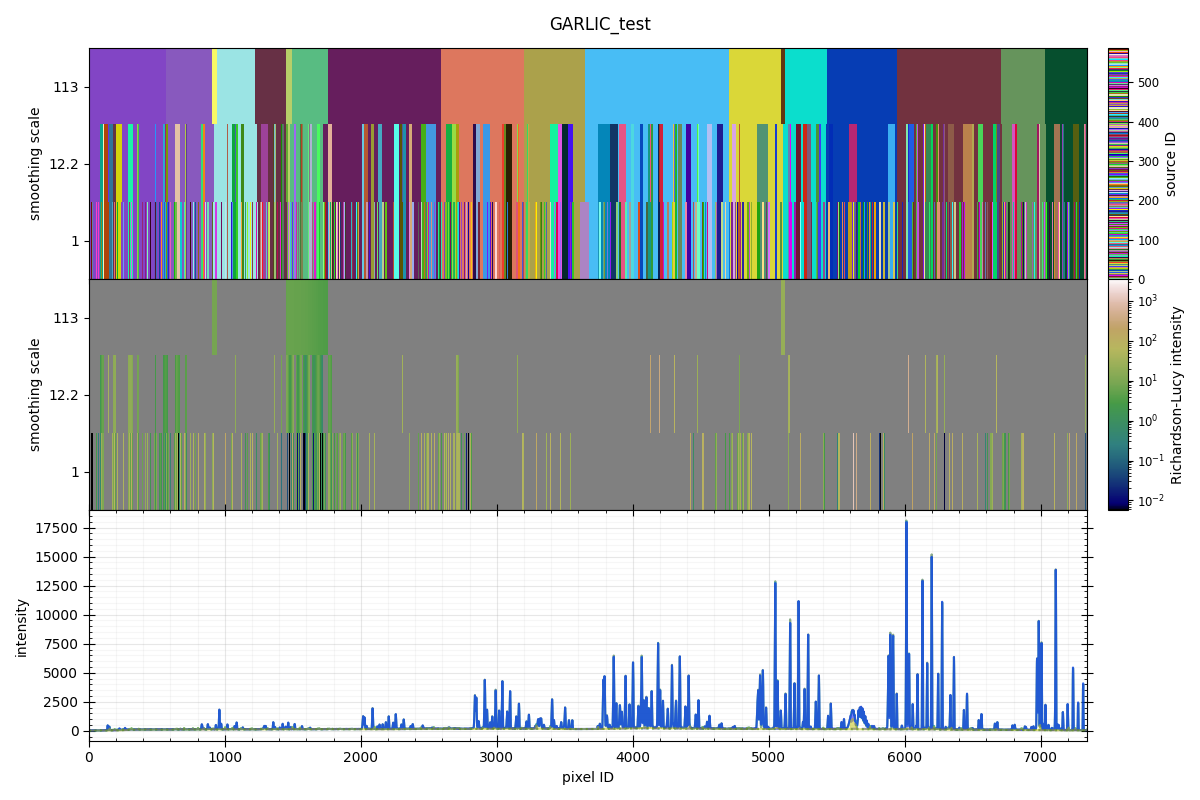

In [38]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
#im = ax.imshow(label[np.newaxis, :],
im = ax.imshow(HOT_labels,
               interpolation='nearest', origin='lower', cmap=label_cmap, norm=label_norm,
              )
ax.set_aspect('auto')
ax.set_ylabel('smoothing scale')
ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')
cb.ax.set_ylabel('source ID')


ax = axes[1, 0]
im = ax.imshow(diffuse_mRL,
               interpolation='nearest', origin='lower', cmap=mRL_cmap, norm=mRL_norm,
              )
ax.set_aspect('auto')
ax.set_ylabel('smoothing scale')
ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
cb = plt.colorbar(im, cax=axes[1, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')
cb.ax.set_ylabel('Richardson-Lucy intensity')

ax = axes[2, 0]
ax.set_ylabel('intensity')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)
#ax.plot(mRL[0], 'k-')

#ax.plot(model_emission, 'b-', alpha=.5)
#ax.plot(diffuse_emission + ndimage.gaussian_filter(mRL[2], diffuse_scale), 'g--', alpha=.5)
ax.plot(model_emission, 'c-', alpha=.5)
ax.plot(diffuse_emission, 'b--', alpha=.5)
ax.plot(diffuse_emission + compact_emission, 'b-', alpha=.5)
ax.plot(background, 'g:', alpha=.5)
#ax.fill_between(np.arange(data.size), background, max_diffuse, color='c', alpha=.5)
ax.plot(diffuse_emission + diffuse_noise, 'y-', alpha=.5)

#ax.plot(np.sum(mRL, axis=0) + background, 'r-', alpha=.5)


ax.set_xlabel('pixel ID')
#ax.set_xlim(5900, 6300)
#ax.set_ylim(-10, 300)
#ax.set_ylim(np.min(background)*.9, np.max(diffuse_emission))

axes[2, 1].axis('off')
plt.show()

In [ ]:
class Explore_lbl_1D(object):
    
    def __init__(self, fig_name, data, estimate, label, parent):
        """Interactive display"""
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 7))
        self.axes = self.fig.subplots(nrows=4, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
        self.fig.suptitle(fig_name)
        self.fig.set_tight_layout(True)

        self.original = data
        self.data_offset = np.nanmin(data)
        #self.RL = RL
        #self.SSF = SSF
        self.total_estimate = estimate
        self.label = label
        self.parent = parent

        self.ax_parent = self.axes[0, 0]
        self.ax_parent_cb = self.axes[0, 1]
        self.ax_lbl = self.axes[1, 0]
        self.ax_lbl_cb = self.axes[1, 1]

        self.ax_im = self.axes[2, 0]
        self.ax_cb = self.axes[2, 1]

        self.ax0 = self.axes[3, 0]
        self.ax0.plot(data, 'k-', alpha=.2)
        self.ax0.set_xlim(0, data.size)
        self.axes[3, 1].axis('off')

        self.widget = widgets.interactive(self.plot_lbl, lbl=widgets.BoundedIntText(value=1, min=1, max=n_sources, continuous_update=False))
        display(self.widget)


    def plot_lbl(self, lbl):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()

        ax = self.ax_parent
        im = ax.imshow(self.parent[self.label],
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
        cb = plt.colorbar(im, cax=self.ax_parent_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        cb.ax.set_ylabel('parent ID')
        
        
        ax = self.ax_lbl
        im = ax.imshow(self.label,
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_yticks(np.arange(smoothing_radii.size), [f'{radius:.3g}' for radius in smoothing_radii])
        cb = plt.colorbar(im, cax=self.ax_lbl_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        cb.ax.set_ylabel('source ID')

        
        RL = get_individual_mRL(mRL, HOT_labels, HOT_parent, lbl)
        self.ax_im.clear()
        im = self.ax_im.imshow(RL,
                               interpolation='nearest', origin='lower',
                               #cmap='gist_earth', norm=colors.LogNorm(vmin=np.min(RL[RL > 1e3*epsilon])))
                               cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99)),
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(RL[RL>0], 1), vmax=np.percentile(RL[RL>0], 99)),
                              )
        self.ax_im.set_aspect('auto')
        cb = plt.colorbar(im, cax=self.ax_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        self.fig.canvas.draw_idle()
        

        ax = self.ax0
        ax.clear()

        #RL = RL[np.newaxis, :] * self.SSF[:, np.newaxis]
        estimate = np.empty_like(RL)
        for i, radius in enumerate(smoothing_radii):
            #self.ax0.plot(original_pixel, RL[i], 'k-', alpha=.1)
            estimate[i] = ndimage.gaussian_filter(RL[i], radius)
        estimate = np.sum(estimate, axis=0)
        #print(np.min(estimate))
        
        fraction = estimate/self.total_estimate
        #estimate_data_offset = np.sum(estimate * ((self.boosted_data+self.data_offset)*fraction - estimate)) / np.sum(estimate)
        final_estimate = estimate #+ estimate_data_offset*np.sqrt(fraction/np.max(fraction))
        #print(estimate_data_offset, np.max(fraction))
        #estimate = self.boosted_data*fraction + self.data_offset*np.mean(fraction)
        #print(f'area: {np.sum(fraction):.2f} ({area[lbl]}),',
        #      f'flux: {np.nansum(final_estimate):.2f} ({test_stat[lbl]:.2f}),',
        mu = np.nansum(final_estimate) / np.count_nonzero(final_estimate > 0)
        print(f'area: {np.sum(fraction):.2f} ({np.count_nonzero(final_estimate[final_estimate <= mu] > 0)} + {np.count_nonzero(final_estimate[final_estimate > mu] > 0)} = {np.count_nonzero(final_estimate > 0)}),',
              f'flux: {np.nansum(final_estimate):.2f} ({np.nansum(final_estimate[final_estimate <= mu]):.2f}, {np.nansum(final_estimate[final_estimate > mu]):.2f}),',
              f'mean:{mu:.3f}',
             )
        print()

        #ax.plot(original_pixel, (self.boosted_data+self.data_offset)*fraction, 'r-.', alpha=.5)

        ax.plot(self.original, 'k-', alpha=.3)
        ax.plot(self.total_estimate + background, 'b-', alpha=.25)

        
        ax.plot(np.sum(RL, axis=0) + background, 'r-', alpha=.25)
        ax.plot(estimate + background, 'g-', alpha=.5)


        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')
        #ax.set_yscale('log')
        ax.set_ylim(.9*self.data_offset, 3e5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #self.ax0.set_xlim(5000, 5300)


if len(data.shape) == 1:
    estimate = np.empty_like(mRL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(mRL[i], radius)
    estimate = np.sum(estimate, axis=0)

    #for i, radius in enumerate(smoothing_radii):
    #     mRL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    #RL = np.nansum(mRL, axis=0)
    #SSF_amplitude = np.nanmedian(mRL/RL[np.newaxis, :], axis=1)
    #print(rms_residual)
    x = Explore_lbl_1D(object_name, data, estimate, HOT_labels, HOT_parent)

In [ ]:
true_source[343]

In [ ]:
np.nansum(data-background), np.sqrt(np.nanstd(data-background-estimate)), np.nanmean(data-background-estimate), np.nanmedian(data-background-estimate)

In [ ]:
np.nanmedian(data-background), np.nanmean(data-background), np.nanstd(data-background-estimate)

In [ ]:
np.nanmedian(estimate), np.nanmean(estimate)

# --- OLD STUFF ---

In [ ]:
'''
fig_name = 'bg_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False)
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-', alpha=.3)
ax.plot(data, 'k-', alpha=.2)
#ax.axhline(data_offset, c='r', ls=':', alpha=.5)
ax.plot(background, 'y-', alpha=.5)
ax.plot(background + residual_above_bg, 'y:', alpha=.5)
ax.fill_between(np.arange(data.size), background, background+2*residual_above_bg, color='y', alpha=.1)


ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)
ax.set_ylim(np.min(background-residual_above_bg), np.max(background+4*residual_above_bg)*1.1)

plt.show()
'''
,

In [ ]:
'''
estimate = background + np.sum(mRL, axis=0)
index_minima = scripts.diffuse_emission.find_minima(estimate)

minima = estimate[index_minima] - background[index_minima]
p16, p50 = np.nanpercentile(minima, [16, 50])
mu0 = p50
var0 = (p50 - p16)**2
weight = np.exp(-.5 * (minima - mu0)**2 / var0)
total_weight = np.nansum(weight)
mu1 = np.nansum(weight * minima) / total_weight
var1 = np.nansum(weight * (minima- mu1)**2) / total_weight
var = 1 / (1/var1 - 1/var0)
mu = var * (mu1/var1 - mu0/var0)
diffuse_offset = mu
print(diffuse_offset, np.sqrt(var))
'''
,

In [ ]:
'''
importlib.reload(scripts.multiscale_RL)

n_iter = 0
model = data
mean_below = 0
while n_iter < 10 and mean_residual > mean_below:
    n_iter += 1
    compact_scale, diffuse_scale, background, residual_above_bg = scripts.diffuse_emission.run(model, max_iter=14)
    smoothing_radii = np.array([1, compact_scale, diffuse_scale])
    print(f'--- {n_iter} --- {compact_scale}, {diffuse_scale}')
    
    mRL = scripts.multiscale_RL.run((model - background).clip(min=0), smoothing_radii, .01)
    compact_emission = ndimage.gaussian_filter(mRL[0], 1) + ndimage.gaussian_filter(mRL[1], compact_scale)
    diffuse_residual = ndimage.gaussian_filter(mRL[2], diffuse_scale)
    diffuse_emission = background + diffuse_residual
    model = compact_emission + diffuse_emission
    total = np.nansum(data - background)
    mean_residual = np.nanmean(diffuse_residual)
    mean_below = np.sqrt(np.nanmean(((background - data)**2)[data < background]))
    print(np.nansum(compact_emission)/total, mean_residual, mean_below)
'''
,